In [8]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt

(182, 218, 182)


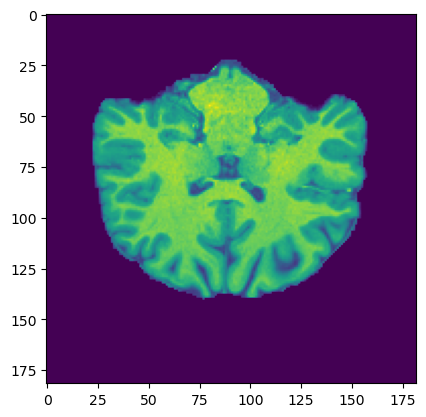

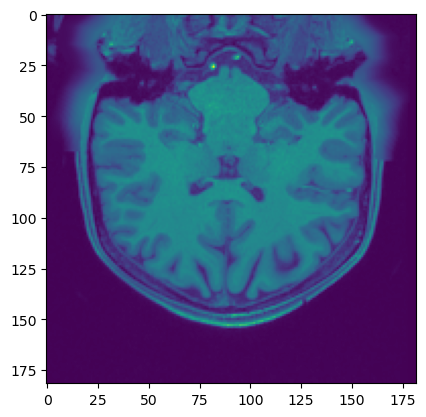

In [14]:
image1 = sitk.ReadImage("../MedIA_Project2/001/T1w_1mm_bet.nii.gz", imageIO="NiftiImageIO")
image2 = sitk.ReadImage("../MedIA_Project2/001/T1w_1mm.nii.gz", imageIO="NiftiImageIO")
# sitk.Show(image)
imarr1 = sitk.GetArrayFromImage(image1)
imarr2 = sitk.GetArrayFromImage(image2)
print(imarr1.shape)
plt.figure()
plt.imshow(imarr1[:, 100, :])
plt.figure()
plt.imshow(imarr2[:, 100, :])